In [16]:
import nltk
import yaml
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd


# To Run the model on Online News

In [128]:
import requests
url = ('https://newsapi.org/v2/everything?'
       'q=brunei&human&rights'
       'from=2019-03-22&'
       'sortBy=popularity&'
       'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
response = requests.get(url)
a=response.json()
print(response.json())
import json
with open('data.json', 'w') as outfile:
    json.dump(a, outfile)
file1 = open("bruneihr.txt","r") 

{'totalResults': 2633, 'articles': [{'content': 'An American college admissions scandal offered a window into the inequities of the application process. But what about the campuses themselves?\r\nStudents at the University of Southern California, which figures prominently in the indictment in the scheme, desc… [+614 chars]', 'url': 'https://www.nytimes.com/2019/04/04/briefing/rupert-murdoch-trump-tax-returns-mueller.html', 'author': 'MELINA DELKIC', 'publishedAt': '2019-04-04T04:24:13Z', 'source': {'name': 'The New York Times', 'id': 'the-new-york-times'}, 'title': 'President Trump, Brexit, Brunei: Your Thursday Briefing', 'description': 'Attorney General William Barr at the White House on Monday.', 'urlToImage': 'https://static01.nyt.com/images/2019/04/03/briefing/04042019ambriefing-euro-promo/04042019ambriefing-euro-slide-PE63-facebookJumbo.jpg'}, {'content': 'At a time when Islams place in the modern world is a matter of global contention, Brunei, a small monarchy in Southeast Asia,

# Run Model on a piece of text or file

In [22]:
file1 = open("outputnord.txt","r",encoding='cp1252')
res=[]
text="""In Johan Galtung's 1969 paper, "Violence, Peace and Peace Research,"[1] he presents his theory of the Conflict
Triangle, a framework used in the study of peace and conflict, with the purpose of defining the three key elements
of violence that form this "triangle." The theory is based on the principle that peace must be defined by widely 
accepted social goals, and that any state of peace is characterized by the absence of violence. When a conflict has 
features of all three areas of violence, the result is a more consolidated, static state of violence in a 
social system, which may include a conflict or a nation-state, whereas the absence of these three 
typologies of violence results in peace."""
#for line in text:
    
sentences = sent_tokenize(text)
tokenized_sentences = [word_tokenize(sent) for sent in sentences]
#postag=[nltk.pos_tag(toksent) for toksent in tokenized_sentences ]
#postag

pos = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
#adapt format
pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
res.append(pos)

In [23]:
res

[[[('In', 'In', ['IN']),
   ('Johan', 'Johan', ['NNP']),
   ('Galtung', 'Galtung', ['NNP']),
   ("'s", "'s", ['POS']),
   ('1969', '1969', ['CD']),
   ('paper', 'paper', ['NN']),
   (',', ',', [',']),
   ('``', '``', ['``']),
   ('Violence', 'Violence', ['NN']),
   (',', ',', [',']),
   ('Peace', 'Peace', ['NNP']),
   ('and', 'and', ['CC']),
   ('Peace', 'Peace', ['NNP']),
   ('Research', 'Research', ['NNP']),
   (',', ',', [',']),
   ("''", "''", ["''"]),
   ('[', '[', ['VBZ']),
   ('1', '1', ['CD']),
   (']', ']', ['NN']),
   ('he', 'he', ['PRP']),
   ('presents', 'presents', ['VBZ']),
   ('his', 'his', ['PRP$']),
   ('theory', 'theory', ['NN']),
   ('of', 'of', ['IN']),
   ('the', 'the', ['DT']),
   ('Conflict', 'Conflict', ['NNP']),
   ('Triangle', 'Triangle', ['NNP']),
   (',', ',', [',']),
   ('a', 'a', ['DT']),
   ('framework', 'framework', ['NN']),
   ('used', 'used', ['VBN']),
   ('in', 'in', ['IN']),
   ('the', 'the', ['DT']),
   ('study', 'study', ['NN']),
   ('of', 'of', ['

# Sentiment Analysis Model

In [24]:
class DictionaryTagger(object):
    def __init__(self, dictionary_paths):
        files = [open(path, 'r') for path in dictionary_paths]
        dictionaries = [yaml.load(dict_file) for dict_file in files]
        map(lambda x: x.close(), files)
        self.dictionary = {}
        self.max_key_size = 0
        for curr_dict in dictionaries:
            for key in curr_dict:
                if key in self.dictionary:
                    self.dictionary[key].extend(curr_dict[key])
                else:
                    self.dictionary[key] = curr_dict[key]
                    self.max_key_size = max(self.max_key_size, len(key))

    def tag(self, postagged_sentences):
        return [self.tag_sentence(sentence) for sentence in postagged_sentences]

    def tag_sentence(self, sentence, tag_with_lemmas=False):
        """
        the result is only one tagging of all the possible ones.
        The resulting tagging is determined by these two priority rules:
            - longest matches have higher priority
            - search is made from left to right
        """
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while (i < N):
            j = min(i + self.max_key_size, N) #avoid overflow
            tagged = False
            while (j > i):
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                expression_lemma = ' '.join([word[1] for word in sentence[i:j]]).lower()
                if tag_with_lemmas:
                    literal = expression_lemma
                else:
                    literal = expression_form
                if literal in self.dictionary:
                    #self.logger.debug("found: %s" % literal)
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, expression_lemma, taggings)
                    if is_single_token: #if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][2]
                        tagged_expression[2].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence


In [25]:
def value_of(sentiment):
    if sentiment == 'positive': return 1
    if sentiment == 'negative': return -1
    return 0

def sentence_score(sentence_tokens, previous_token, acum_score):    
    if not sentence_tokens:
        return acum_score
    else:
        current_token = sentence_tokens[0]
        tags = current_token[2]
        token_score = sum([value_of(tag) for tag in tags])
        if previous_token is not None:
            previous_tags = previous_token[2]
            if 'inc' in previous_tags:
                token_score *= 2.0
            elif 'dec' in previous_tags:
                token_score /= 2.0
            elif 'inv' in previous_tags:
                token_score *= -1.0
        return sentence_score(sentence_tokens[1:], current_token, acum_score + token_score)

def sentiment_score(review):
    return sum([sentence_score(sentence, None, 0.0) for sentence in review])

In [26]:
dicttagger = DictionaryTagger([ 'positive.yml', 'negative.yml','strong.yml','weak.yml','inv.yml'])
score=0
for i in range(len(res)):
    dict_tagged_sentences = dicttagger.tag(res[i])


    score += sentiment_score(dict_tagged_sentences)
print(score)

-9.0


In [27]:
for s in dict_tagged_sentences:
        print(s[1])


('Johan', 'Johan', ['NNP'])
('theory', 'theory', ['NN'])
('a', 'a', ['DT'])


# Words annotated with their lexico

In [28]:
dict_tagged_sentences

[[('In', 'In', ['IN']),
  ('Johan', 'Johan', ['NNP']),
  ('Galtung', 'Galtung', ['NNP']),
  ("'s", "'s", ['POS']),
  ('1969', '1969', ['CD']),
  ('paper', 'paper', ['NN']),
  (',', ',', [',']),
  ('``', '``', ['``']),
  ('violence', 'violence', ['negative', 'NN']),
  (',', ',', [',']),
  ('Peace', 'Peace', ['NNP']),
  ('and', 'and', ['CC']),
  ('peace research', 'peace research', ['positive']),
  (',', ',', [',']),
  ("''", "''", ["''"]),
  ('[', '[', ['VBZ']),
  ('1', '1', ['CD']),
  (']', ']', ['NN']),
  ('he', 'he', ['PRP']),
  ('presents', 'presents', ['VBZ']),
  ('his', 'his', ['PRP$']),
  ('theory', 'theory', ['NN']),
  ('of', 'of', ['IN']),
  ('the', 'the', ['DT']),
  ('conflict', 'conflict', ['negative', 'NNP']),
  ('Triangle', 'Triangle', ['NNP']),
  (',', ',', [',']),
  ('a', 'a', ['DT']),
  ('framework', 'framework', ['NN']),
  ('used', 'used', ['VBN']),
  ('in', 'in', ['IN']),
  ('the', 'the', ['DT']),
  ('study', 'study', ['NN']),
  ('of', 'of', ['IN']),
  ('peace', 'peace

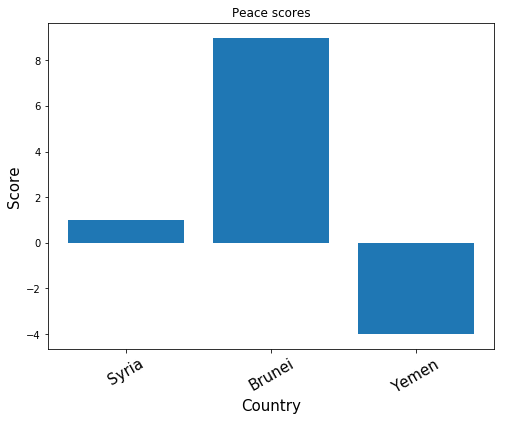

In [107]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(8,6))
label = ['Syria','Brunei','Yemen',]
scores = [1,9,-4]
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, scores)
    plt.xlabel('Country', fontsize=15)
    plt.ylabel('Score', fontsize=15)
    plt.xticks(index, label, fontsize=15, rotation=30)
    plt.title('Peace scores')
plot_bar_x()

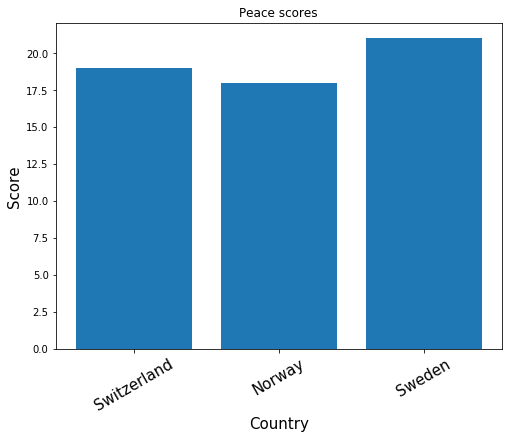

In [98]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(8,6))
label = ['Switzerland','Norway','Sweden']
scores = [19,18,21]
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, scores)
    plt.xlabel('Country', fontsize=15)
    plt.ylabel('Score', fontsize=15)
    plt.xticks(index, label, fontsize=15, rotation=30)
    plt.title('Peace scores')
plot_bar_x()

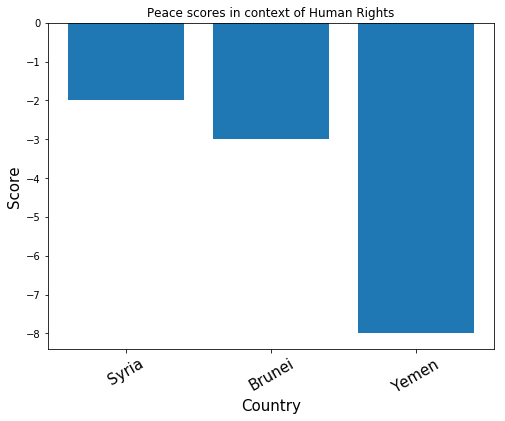

In [145]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(8,6))
label = ['Syria','Brunei','Yemen']
scores = [-2,-3,-8]
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, scores)
    plt.xlabel('Country', fontsize=15)
    plt.ylabel('Score', fontsize=15)
    plt.xticks(index, label, fontsize=15, rotation=30)
    plt.title('Peace scores in context of Human Rights')
plot_bar_x()